# Computer Lab 2, Part I

This notebook consists of instructions, exercises and questions that form the practical part of Lab II, Part I. In this assignment, you will learn the basics of the OpenStack Python APIs that can be used to interact directly with the IaaS services Nova (compute) and Swift (Object Store). Please prepare your solution and answers to questions directly in this notebook, and export it to PDF. Upload that PDF as to the student portal to complete Part I of the Lab.  

In [169]:
import os
import sys
import time
import swiftclient.client
import paramiko
import subprocess

OS_TENANT_NAME="ACC-Course"
OS_PROJECT_NAME="ACC-Course"
OS_USERNAME="shjo0681"
OS_AUTH_URL='http://smog.uppmax.uu.se:5000/v2.0'
OS_PASSWORD='x1xv6565'

os.environ['OS_TENANT_NAME'] = OS_TENANT_NAME
os.environ['OS_PROJECT_NAME'] = OS_PROJECT_NAME
os.environ['OS_USERNAME'] = OS_USERNAME
os.environ['OS_AUTH_URL'] = OS_AUTH_URL
os.environ['OS_PASSWORD'] = OS_PASSWORD


To establish a client connection, we will need to pass a dictionary with information about the tenant, user, credentials and the API Identity endpoint. Here, I have sourced the "openrc.sh file" obtained from the Horizon dashboard in the underlying shell prior to starting the notebook. Hence, in order to actually run the code below, you would need to do the same with your own credentials. 

In [170]:
config = {'user':'shjo0681', 
          'key':'x1xv6565',
          'tenant_name':"ACC-Course",
          'authurl':"http://smog.uppmax.uu.se:5000/v2.0"}

First, we obtain a client connection to Swift (we are usign the v2 APIs)

In [171]:
conn = swiftclient.client.Connection(auth_version=2, **config)

In [172]:
# Create a container, use a UUID to make sure it has a globally unique name. 
import uuid
bucket_name = "lab2_{0}".format(str(uuid.uuid4()))
conn.put_container(bucket_name)

#Saving bucket name for deletion later.
bucket_reference = bucket_name

## Question 1:

What does it mean that the object store has a global, flat namespace? What is the practical consequence for you when using it?

In [173]:
# List containers
(response, bucket_list) = conn.get_account()
for bucket in bucket_list:
    print bucket['name']

ACCA
AJ_48c95173-4b77-467d-aa64-c934f3efeb5a
AJ_5cda2de6-f80c-40db-9ab6-d189dd1946fb
AJ_bc9904ef-9f6d-4c87-b2d8-ed8bbe9ac8e4
A_a8b211e2-d7e0-4016-bf30-2075ad07158e
A_b989361a-b156-4eb7-b0c2-f747aa13ae31
CarlssonBucket
DoktorFalafel
FarezCon
Harry_lab2_65536b3d-4965-4f8d-a513-5db2f82c5dc7
Harry_lab2_7119c0a9-21dd-4b55-a543-e0a5d0f1e4a9
JustAnotherContainer
Lab1
Labb 3, needed files
Lundetainer
Marcus_bucket
MatLab2_023f0b1b-fb91-4f66-bdcf-72f3fc81bcba
MatLab2_2d53a9e7-cc12-45b3-8c02-6c7fe7386127
MatLab2_482b1529-ec01-4836-81e2-da5b86015bf5
MatLab2_5d1555a5-df16-40f1-a10c-a6aa2b3a0cf0
MatLab2_63276e91-a470-4414-bb92-bb50c7fa82de
MatLab2_7d11a714-57c3-4d11-bde2-145ff3c0b79d
MatLab2_8ba15c79-32c3-4ccb-8fdb-923fb4b532af
MatLab2_a0ba73f0-4014-4f7d-a563-26845f3740df
MatLab2_d537e697-26f7-4bc1-b35b-8c3d17e7d277
MavaLab2_73c7d646-335f-4b2e-b409-f5913691f84e
MavaLab2_88ee1622-7de2-4c0e-8eb0-732a13f10cae
MavaLab2_a70b7a68-6ba0-4cfe-ac66-1b1475f36080
Nope_container
PrivateContainer
RuulTainer
Saro

In [174]:
# Put an object in the container
print 'Putting crap into bucket: \n' + bucket_name
object_id = conn.put_object(bucket_name, "test_object", "Hi Swift")

Putting crap into bucket: 
lab2_4731c88c-766f-42c7-820b-23313bea676e


### Excercise 1:

Try to measure the speed with which you can put and get objects to and from Swift usign the API. Conduct your experiment several times to gather statistic and plot a) A estimated distribution of the time taken (in wall clock) to put and read an object of size 10MB in your swift container and b) vary the size of the object from 10kB to 100MB and plot the put and get throughput (in MB/s) times as a function of object size (for the smaller data sizes, you might need to repeat the experiment many times and obtain a statistical average). Include the resulting graphs and a description of your experiment in the report. 

Created a container named: lab2Popcorn
Starting measurments, this might take some time
About halfway through measurments.
Measurments done, preparing the plot.
Populating the interactive namespace from numpy and matplotlib


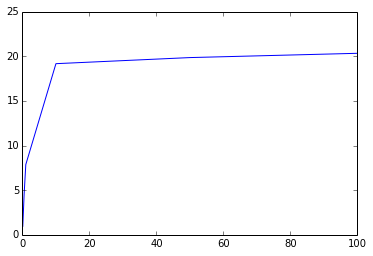

In [175]:
#dd if=/dev/zero of=1MB.img count=1 bs=1M makes a file
def getTime():
    return time.time()
    #return int(round(time.time() * 1000))
def getTimeTaken(start):
    return getTime() - start

#Get a target container
bucket_name = "lab2Popcorn"#.format(str(uuid.uuid4()))
print "Created a container named: " + bucket_name
bucket_exists = 0
(response, bucket_list) = conn.get_account()
for bucket in bucket_list:
    if(bucket['name'] == bucket_name):
        bucket_exists = 1
if(bucket_exists == 0):
    conn.put_container(bucket_name)

def performMeasurement(fileName):
    with open(fileName, 'r') as temp_file:
        startTimer = getTime()
        conn.put_object(bucket_name, fileName, contents=temp_file.read(), content_type='image/jpg')
        conn.get_object(bucket_name, fileName)
        return getTimeTaken(startTimer)

def tenTimesAverage(fileName):
    time = 10
    totalTime = 0
    while time>0:
        totalTime = totalTime + performMeasurement(fileName)
        time = time -1
    return (totalTime / 10)
    
print 'Starting measurments, this might take some time'
time10MB = tenTimesAverage('10MB.img')
time50MB = tenTimesAverage('50MB.img')
print 'About halfway through measurments.'
time100MB = tenTimesAverage('100MB.img')
time1MB = tenTimesAverage('1MB.img')
time10KB = tenTimesAverage('10KB.img')
time50KB = tenTimesAverage('50KB.img')
print 'Measurments done, preparing the plot.'

# Implement you solution here. Hint, the following command
%pylab inline

def changeToMBperSecond(time, itemSize):
    mbItemSize = itemSize
    timeInSeconds = time
    return mbItemSize / timeInSeconds

time10KB = changeToMBperSecond(time10KB, 0.1)
time50KB = changeToMBperSecond(time50KB, 0.5)
time1MB = changeToMBperSecond(time1MB, 1)
time10MB = changeToMBperSecond(time10MB, 10)
time50MB = changeToMBperSecond(time50MB, 50)
time100MB = changeToMBperSecond(time100MB, 100)

xaxis = [0.1,0.5,1,10,50,100]
yaxis = [time10KB, time50KB, time1MB,time10MB,time50MB,time100MB]

# will  make matplotlib/pylab available and plots will be displayed directly in the notebook, for example
plt.plot(xaxis,yaxis)

### Excercise 2:

In [178]:
# Obtain a list of all the object names in your container. 
(response, stuff_list) = conn.get_container(bucket_name)
for stuff in stuff_list:
    print stuff['name']

100MB.img
10KB.img
10MB.img
1MB.img
50KB.img
50MB.img


In the cell below, we obtain a client connection to the Nova endpoint. It can be used to for example start, stop and terminate instances. 

In [176]:
config = {'user':os.environ['OS_USERNAME'], 
          'key':os.environ['OS_PASSWORD'],
          'tenant_name':os.environ['OS_TENANT_NAME'],
          'authurl':os.environ['OS_AUTH_URL']}
from novaclient.client import Client
nc = Client('2',**config)


### Excercise 3:

Boot a new instance (hint, look client.server in the API docs) with flavor 'm1.medium' (remember to provide an ssh-key so that you can access it later). In booting the instance, use the mechanism of 'user_data' (learn about this in the openstack and 'cloud-init' documentations) to provide a startup-script to 1. Update the instance, 2. install 'git', 'cowsay' and 'flask'. 

In [188]:
# Use paramiko to access your instance and, using ssh, start the cowsay service on your instance,
# usinf the same command as in Task 4, lab 1. 

# New nova client since other API doesn't work
from novaclient import client as novaclient
creds = {}
creds['username'] = os.environ['OS_USERNAME']
creds['api_key'] = os.environ['OS_PASSWORD']
creds['auth_url'] = os.environ['OS_AUTH_URL']
creds['project_id'] = os.environ['OS_PROJECT_NAME']
nova = novaclient.Client('2', **creds)

def ServerExists(name):
    serverExists = False
    listServers = nova.servers.list(detailed=True)
    for server in listServers:
        if(server.name == name):
            serverExists = True
    return serverExists

def setImage(preferedImage):
    imageExists = False
    listImages = nova.images.list(detailed=True)
    for image in listImages:
        if(image.name == preferedImage):
            return preferedImage
    return listImages[0].name

def getFreeFloatingIP():
    listFloatingIps = nova.floating_ips.list()
    for ip in listFloatingIps:
        if(ip.fixed_ip == None):
            return ip
    return nova.floating_ips.create()

serverName = 'CowSaysPopcorn'
flavor = nova.flavors.find(name='m1.large')
image = nova.images.find(name=setImage('readyConfig'))
image = '99f4625e-f425-472d-8e21-7aa9c3db1c3e'
connected = True

#rm -rf /var/lib/cloud/*
user_data_stuff = ('#!/bin/bash \n' 
                    'sudo apt-get update -y && sudo apt-get install python-pip -y \n'
                    'sudo apt-get install cowsay -y \n pip install Flask \n sudo apt-get install git -y')
#user_data_stuff = '#!/bin/bash\nsudo apt-get install python-pip\necho Update ran TEST!!\n sudo apt-get install git\nsudo apt-get install fortune cowsay\npip install Flask'

instance = nova.servers.create(name=serverName, flavor=flavor, image=image, userdata=user_data_stuff, key_name='cowsayPopcornKey', security_groups=['default'])
print instance
#instance = nova.servers.find(name=serverName)
time.sleep(10)
floatingIp = getFreeFloatingIP()
nova.servers.add_floating_ip(instance, floatingIp)

print floatingIp
time.sleep(3)

<Server: CowSaysPopcorn>
<FloatingIP fixed_ip=None, id=926b845c-6a14-4e23-97ad-e53effaa01b1, instance_id=None, ip=130.238.29.71, pool=ext-net>


In [189]:
ssh = paramiko.SSHClient()
ssh.load_system_host_keys()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

ssh.connect(floatingIp.ip, username='ubuntu', key_filename='cowsaypopcornKey.key')
com = 'sudo git clone https://www.github.com/TDB-UU/csaas'
stdin, stdout, stderr = ssh.exec_command(com)

print 'SSH connection successful'
stderr = stderr.readlines()
stdout = stdout.readlines()
print stdout
print stderr

com = 'python /home/ubuntu/csaas/cowsay/app.py'
stdin, stdout, stderr = ssh.exec_command(com)
print stdout
print stderr

ssh.close()
print 'closing connection'
time.sleep(3)
#This code is tested and working.
print com
print floatingIp.ip
command = 'curl -i http://' + floatingIp.ip + ':5000/cowsay/api/v1.0/saysomething'
print "Running: " + command
p = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
(output, err) = p.communicate()
print "Output: \n", output

# Make a request to the cowsay REST API and display the response inline in the notebook

SSH connection successful
[]
[u'sudo: unable to resolve host cowsayspopcorn\n', u"Cloning into 'csaas'...\n"]
<paramiko.ChannelFile from <paramiko.Channel 1 (open) window=2097152 -> <paramiko.Transport at 0x888ec250L (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>
<paramiko.ChannelFile from <paramiko.Channel 1 (open) window=2097152 -> <paramiko.Transport at 0x888ec250L (cipher aes128-ctr, 128 bits) (active; 1 open channel(s))>>>
closing connection
python /home/ubuntu/csaas/cowsay/app.py
130.238.29.71
Running: curl -i http://130.238.29.71:5000/cowsay/api/v1.0/saysomething
Output: 
HTTP/1.0 200 OK
Content-Type: text/html; charset=utf-8
Content-Length: 175
Server: Werkzeug/0.10.4 Python/2.7.6
Date: Thu, 01 Oct 2015 13:23:27 GMT

 _______________
< Hello student >
 ---------------
        \   ^__^
         \  (oo)\_______
            (__)\       )\/\
                ||----w |
                ||     ||



### Question 2:

The above excersise showed a low-level way of 'contextualization' using user data 'cloud-init'. Do some reserach online and discuss alternative tools and techniques for contextualization of your VMs. Discuss the difference between instance meta-data and user-data. Some links to get you started:

http://docs.openstack.org/user-guide/cli_provide_user_data_to_instances.html
http://cernvm.cern.ch/portal/contextualisation
https://cloudinit.readthedocs.org/en/latest/

Aim for the equivalent of ~1/2 page of an A4 paper, 12pt font, 2cm margins.  



### Excersise 4:

Use the Swift and Nova APIs to terminate your instance, to delete all the objects from your bucket, and then finally to delete the container. 

In [190]:
# Clean up container in Swift
print bucket_reference
print bucket_name
print conn

for stuff in conn.get_container(bucket_reference)[1]:
    conn.delete_object(bucket_reference, stuff['name'])

for stuff in conn.get_container(bucket_name)[1]:
    conn.delete_object(bucket_name, stuff['name'])
#print conn.delete_container(bucket_reference)
print conn.delete_container(bucket_name)

ERROR:swiftclient:Container GET failed: http://smog.uppmax.uu.se:8080/swift/v1/lab2Popcorn?format=json 404 Not Found   {"Code":"NoSuchBucket"}
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/swiftclient/client.py", line 1390, in _retry
    service_token=self.service_token, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/swiftclient/client.py", line 714, in get_container
    http_response_content=body)
ClientException: Container GET failed: http://smog.uppmax.uu.se:8080/swift/v1/lab2Popcorn?format=json 404 Not Found   {"Code":"NoSuchBucket"}


lab2_4731c88c-766f-42c7-820b-23313bea676e
lab2Popcorn


ClientException: Container GET failed: http://smog.uppmax.uu.se:8080/swift/v1/lab2Popcorn?format=json 404 Not Found   {"Code":"NoSuchBucket"}

In [191]:
# Terminate all your running instances
instance.delete()